In [1]:
import pandas as pd  
# 指向Intergated-DATASET-D.csv的地址（这个文件是预处理得到的）
DATASET_B_PATH_WIN = 'F:\大学\第40期PRP\特征提取\\1_feature_analysis\Intergated-DATASET-D.csv'
# 读取数据文件 
data = pd.read_csv(DATASET_B_PATH_WIN).drop(['Unnamed: 0'], axis=1)


In [2]:
# 设置需要处理的空间网格区间的边界
# 范围不能太大，会超内存而无法运行

ROW_LIM_DOWN = int(data_in.row_id.min())
ROW_LIM_UP = int(data_in.row_id.max() - 80)
COL_LIM_DOWN = int(data_in.col_id.min())
COL_LIM_UP = int(data_in.col_id.max() - 80)
print((ROW_LIM_DOWN, ROW_LIM_UP, COL_LIM_DOWN, COL_LIM_UP))

(-139, -80, 0, 58)


In [3]:
# 选定待处理的空间网格区域
data = data.loc[(data.row_id >= ROW_LIM_DOWN)&(data.row_id <= ROW_LIM_UP) &(data.col_id >= COL_LIM_DOWN) & (data.col_id <= COL_LIM_UP)]
# 将所有网格id转换成int型
for c in ['row_id', 'col_id', 'time_id']:  
    data[c] = data[c].astype(int)
# 将date和id处理成正整数，然后排序
data['date'] -= data['date'].min()
data['row_id'] -= data['row_id'].min()
data['col_id'] -= data['col_id'].min()
data['time_id'] -= data['time_id'].min()
data = data.sort_values(['date', 'row_id', 'col_id', 'time_id']).reset_index(drop=True)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [4]:
# 当前的data中存在着NaN值和缺失的网格，需要将NaN改成0，以及将缺失网格补全，由下面这个函数实现
def grid_recovery(df_, cols=[], lens=[]):
    df = df_.copy()
    lcols = len(cols)
    llens = len(lens)
    
    if lcols != llens: # 确保输入的网格名称和网格长度信息的长度一致
        raise ValueError(f'Lengths of cols ({lcols}) and lens ({llens}) mismatch.')
    
    recovery_df = None
    for c, l in zip(cols, lens):
        tmp_df = pd.DataFrame({c:range(l)})
        tmp_df['flag'] = True
        if recovery_df is None:
            recovery_df = tmp_df.copy()
        else:
            recovery_df = recovery_df.merge(tmp_df, 'left', 'flag')
    
    del recovery_df['flag']
    
    df = pd.merge(recovery_df, df, on=['date','row_id', 'col_id', 'time_id'])
    df = df.fillna(0)
    return df
    
NROWS = ROW_LIM_UP - ROW_LIM_DOWN + 1 # 空间网格行数  
NCOLS = COL_LIM_UP - COL_LIM_DOWN + 1 # 空间网格列数  
NTIME = data.time_id.max() - data.time_id.min() + 1 # 时间网格数  
NDATE = 30 # 日期网格数
data = grid_recovery(data, ['date', 'row_id', 'col_id', 'time_id'], [NDATE, NROWS, NCOLS, NTIME])  
for c in ['volume', 'stopNum']:  
    data[c] = data[c].astype(int) # 调整数据类型 

In [5]:
# 当前网格数太多了，可以进一步合并
data['hourid'] = data['time_id'] // 6 # 合并时间网格  
data['new_rowid'] = data.row_id // 2 # 合并空间网格  
data['new_colid'] = data.col_id // 2  
speed = data.groupby( # 计算合并网格后各网格的流量  
    ['date', 'new_rowid', 'new_colid', 'hourid']).aveSpeed.sum().reset_index()  
speed.columns = ['date', 'row_id', 'col_id', 'hourid', 'gridSpeed']  

In [6]:
TIME_UNIT = data.groupby('hourid').size().count() # 每个小时里所包含的hourid的数量
TIME_UNIT

45

In [7]:
from math import ceil

In [8]:
speed_pivot = speed.pivot_table(  
    index=['date', 'hourid', 'row_id'],  
    columns='col_id',  
    values='gridSpeed').fillna(0).reset_index() # 网格转换  
speed_pivot['timeseq'] = speed_pivot['date'] * TIME_UNIT + speed_pivot['hourid'] # 时间序号  
speed_pivot_np = speed_pivot[[c for c in range(ceil(NCOLS/2))]].values # 提取速度数值

In [9]:
speed_pivot

col_id,date,hourid,row_id,0,1,2,3,4,5,6,...,21,22,23,24,25,26,27,28,29,timeseq
0,0,0,0,0.000000,0.000000,0.000000,37.728247,15.018503,124.086013,108.547353,...,3.455001,8.188561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,0,1,0.000000,25.897002,48.193838,82.028589,215.656974,0.000000,0.000000,...,21.710029,59.018702,13.257737,96.335529,237.514607,79.100958,0.000000,0.000000,0.000000,0
2,0,0,2,15.291832,9.487548,0.000000,188.900197,0.000000,0.000000,0.000000,...,0.000000,94.765247,168.918576,131.114918,9.691047,3.455001,0.000000,0.000000,0.000000,0
3,0,0,3,0.000000,0.000000,53.631787,87.961468,0.000000,0.000000,0.000000,...,75.121591,104.025709,97.573224,11.946163,19.631729,0.000000,0.000000,0.000000,0.000000,0
4,0,0,4,0.000000,4.611076,105.069507,0.000000,0.000000,0.000000,0.000000,...,0.000000,118.592410,72.894937,3.455001,0.000000,0.000000,0.000000,17.455524,55.780484,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40495,29,44,25,86.093461,272.787555,83.450174,243.652568,31.530748,0.000000,0.000000,...,97.602237,148.502143,199.156036,38.263654,0.000000,0.000000,0.000000,78.999622,19.227188,1349
40496,29,44,26,43.283563,221.176400,230.587808,141.909922,51.987837,0.000000,0.000000,...,86.685256,74.162304,172.699487,169.727179,0.000000,37.891629,67.370874,83.693908,0.000000,1349
40497,29,44,27,0.000000,189.466380,218.838309,39.644134,92.889331,35.853763,26.989958,...,0.000000,78.329423,89.013772,134.211587,10.650871,18.192569,0.000000,38.317001,0.000000,1349
40498,29,44,28,105.730093,217.931077,130.129925,166.364760,208.338677,127.264493,57.652804,...,74.046575,58.763244,0.000000,178.266834,0.000000,0.000000,6.128748,60.624842,46.465889,1349


In [10]:
import numpy as np

# 数据增强
def gen_movie(df, nrows=ceil(NROWS/2), ncols=ceil(NCOLS/2), ntime=30*TIME_UNIT, win_s=10, win_t=3):  
    n_i = nrows - win_s + 1   # 18
    n_j = ncols - win_s + 1   # 25
    piece = []  
    for t in range(TIME_UNIT, ntime+1):  
        for i in range(n_i):  
            for j in range(n_j):  
                # 周期特征  
                prd_piece = df[t - TIME_UNIT:t - TIME_UNIT + 1, i:i+win_s, j:j+win_s]  
                # 邻近特征  
                nbr_piece = df[t-win_t:t, i:i+win_s, j:j+win_s]  
                piece.append(np.vstack([prd_piece, nbr_piece]))  
    return np.stack(piece)  

movie = gen_movie(np.asarray(speed_pivot_np.reshape(30*TIME_UNIT, ceil(NROWS/2), ceil(NCOLS/2)), order='C'))  
np.save('data_x.npy', movie[:, :3])  
np.save('data_y.npy', movie[:, 3])  

In [24]:
np.shape(movie)

(575946, 4, 10, 10)

In [11]:
import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras.layers import Conv2D, BatchNormalization  
from tensorflow.keras.layers import Activation, MaxPooling2D  
from tensorflow.keras.regularizers import l2
# 卷积层
def conv_layer(inputs,  
             num_filters=16,  
             kernel_size=3,  
             strides=1,  
             data_format='channels_first',  
             activation='relu',  
             batch_normalization=True,  
             maxpooling=True,  
             pool_size=2,  
             pool_strides=2):  
    conv = Conv2D(num_filters,  
                 kernel_size=kernel_size,  
                 strides=strides,  
                 padding='same',  
                 data_format=data_format,  
                 kernel_regularizer=l2(1e-4))  
    x = conv(inputs)  # 卷积
    if batch_normalization:
        x = BatchNormalization()(x) # 批归一化
    if activation is not None:
        x = Activation(activation)(x) # 激活函数
    if maxpooling:
        x = MaxPooling2D(pool_size=pool_size,  
                        strides=pool_strides,  
                        data_format=data_format,  
                        padding='same')(x) # 池化
    return x

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:

from tensorflow.keras.layers import UpSampling2D  
def upsample_layer(inputs,  
                up_size=2,  
                interpolation='nearest',  
                data_format='channels_first'):
    upsample = UpSampling2D(size=up_size,
                    data_format=data_format,
                    interpolation=interpolation)  
    x = upsample(inputs) # 上采样
    return x

In [14]:
from tensorflow.keras.layers import Input, Flatten, Dense  
from tensorflow.keras.models import Model  
def cnn_model(input_shape):  
    inputs = Input(shape=input_shape)  
    x = conv_layer(inputs, 16, pool_strides=1)  
    x = conv_layer(x, 32, pool_strides=1)  
    x = conv_layer(x, 32, pool_strides=1)  
    x = conv_layer(x, 16)  
    x = upsample_layer(x, 2)  
    x = conv_layer(x, 1, maxpooling=False)  
    y = Flatten(data_format='channels_first')(x)  
    y = Dense(128, activation='relu')(y)  
    y = Dense(128, activation='relu')(y)  
    outputs = Dense(100, activation='relu')(y)  
    # 建立模型  
    model = Model(inputs=inputs, outputs=outputs)  
    return model

In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error      
from tensorflow.keras.callbacks import EarlyStopping    
SEED = 233  # 随机种子    
np.random.seed(SEED)    
tf.random.set_random_seed(SEED)

In [16]:
data_x = np.load('data_x.npy')    
data_y = np.load('data_y.npy')    
data_x = data_x.astype('float32')    
data_y = data_y.astype('float32')

In [17]:
N_SAMPLE_PER_HOUR = (ceil(NROWS/2) - 10 + 1) * (ceil(NCOLS/2) - 10 + 1) # 计算数据增强（裁剪）之后，一个hourid内的数据数量
N_SAMPLES_LAST_DAY = TIME_UNIT * N_SAMPLE_PER_HOUR #计算最后一天的样本（数据）量


data_x /= 1404 # 归一化  
data_y /= 1404 # 归一化  #TODO:此处归一化的方法存疑
train_x, train_y = data_x[:-N_SAMPLES_LAST_DAY], data_y[:-N_SAMPLES_LAST_DAY] # 训练集     
test_x, test_y = data_x[-N_SAMPLES_LAST_DAY:], data_y[-N_SAMPLES_LAST_DAY:] # 测试集
model = cnn_model(train_x.shape[1:])      
opt = keras.optimizers.Adam(learning_rate=4e-4)      
model.compile(loss='mse',      
              optimizer=opt,      
              metrics=['mae', 'mse'])      
batch_size = 32 # 训练批次大小    
epochs = 30  # 训练轮数    
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # 早停策略    
model.fit(train_x, train_y.reshape(-1, 100),      
        batch_size=batch_size,      
        epochs=epochs,       
        validation_split=0.2,      
        callbacks=[earlystop],      
        shuffle=True) # 模型训练

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 444880 samples, validate on 111221 samples
Epoch 1/30
444880/444880 [==============================] - 132s 298us/sample - loss: 0.0021 - mean_absolute_error: 0.0292 - mean_squared_error: 0.0016 - val_loss: 0.0011 - val_mean_absolute_error: 0.0231 - val_mean_squared_error: 0.0011
Epoch 2/30
444880/444880 [==============================] - 126s 282us/sample - loss: 9.8718e-04 - mean_absolute_error: 0.0216 - mean_squared_error: 9.2492e-04 - val_loss: 0.0011 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0010
Epoch 3/30
444880/444880 [==============================] - 130s 292us/sample - loss: 8.8316e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 8.2475e-04 - val_loss: 8.3415e-04 - val_mean_absolute_error: 0.0197 - val_mean_squared_error: 7.7764e-04
Epoch 4/30
444880/444880 [==============================] - 136s 305us/sample - loss: 8.3107e-04 - mean_absolute_error: 0.0195 - 

In [18]:
# 计算误差
predictions_test = model.predict(test_x, batch_size=512)    
mae_test = mean_absolute_error(predictions_test * 1404, test_y.reshape(-1, 100) * 1404)    
mse_test = mean_squared_error(predictions_test * 1404, test_y.reshape(-1, 100) * 1404)    
print(mae_test, mse_test, np.sqrt(mse_test)) # 测试集误差 

25.007273 1372.3293 37.044964


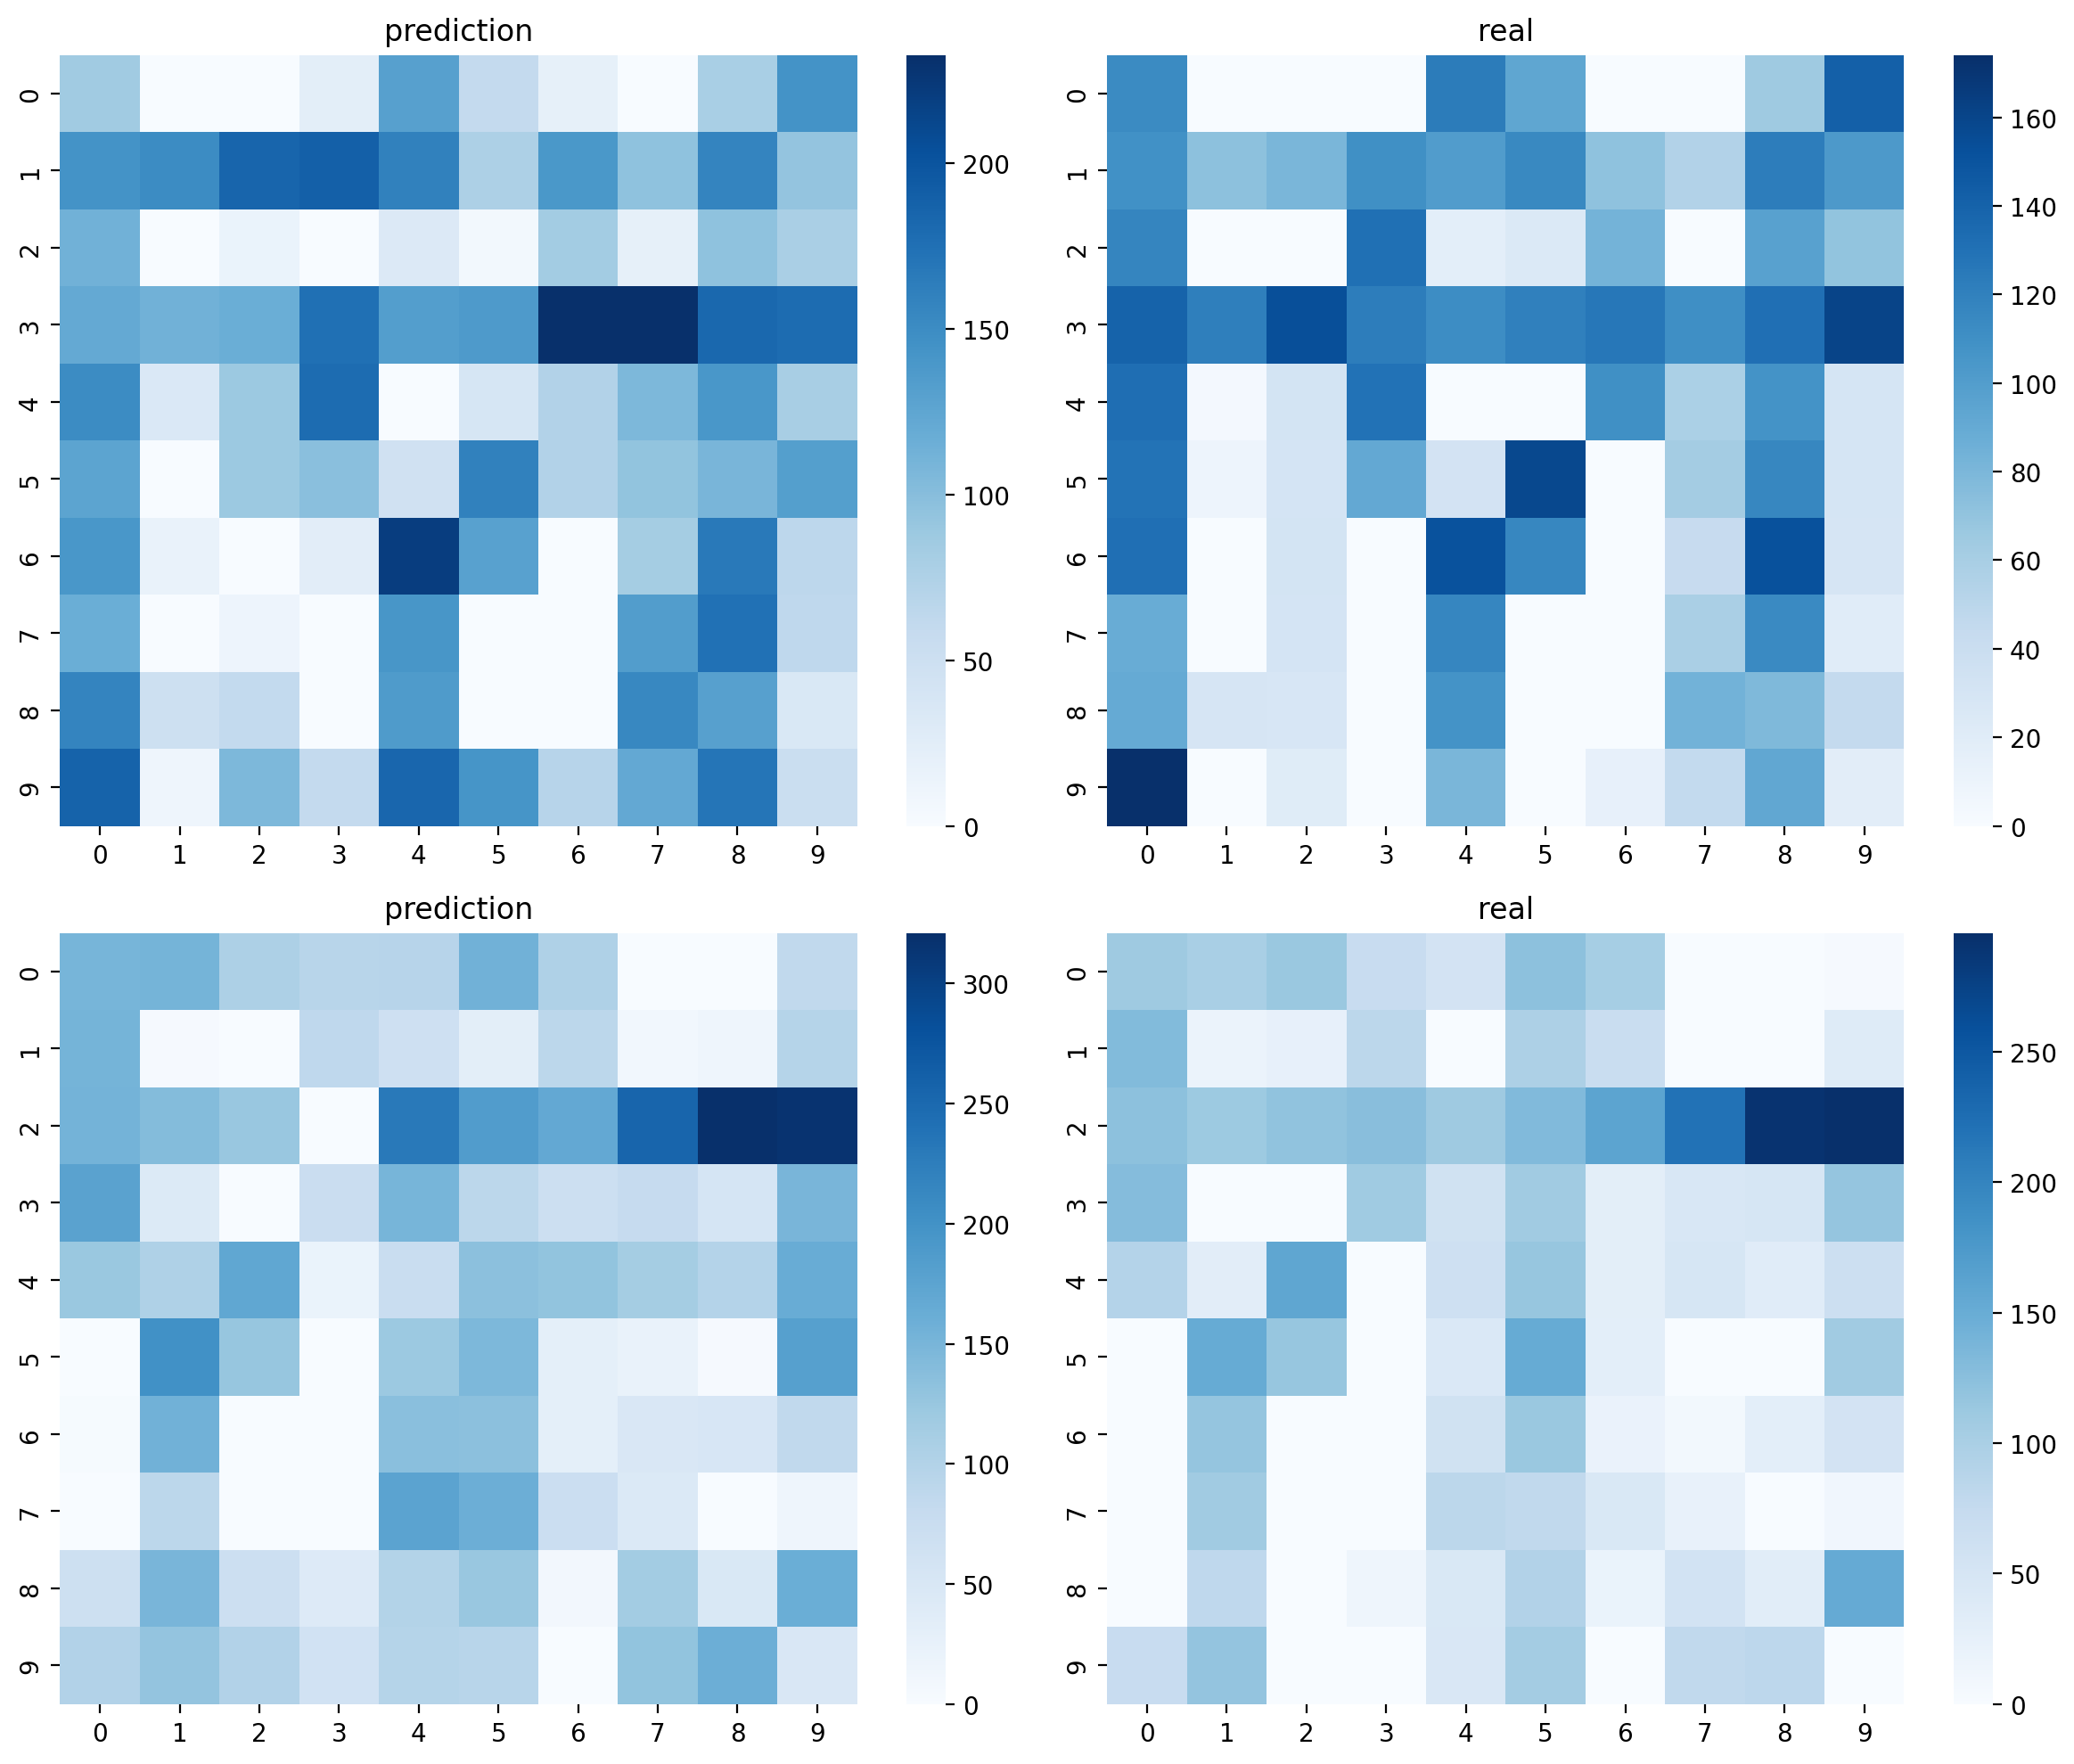

In [21]:
# 预测结果可视化
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=200)
for idx, (axi, volframe) in enumerate(zip(ax.ravel(), [
    predictions_test[56].reshape(10,-1),
    test_y[56],
    predictions_test[80].reshape(10,-1),
    test_y[80],
])):
    sns.heatmap(volframe * 1404, vmin=0, cmap='Blues', ax=axi)
    if idx % 2 == 0:
        axi.set_title('prediction')
    else:
        axi.set_title('real')
plt.tight_layout()
plt.show()
